<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

## HOW TO obtain data given parameters extracted from an ESO catalogue

The ESO Archive provides access to reduced or fully calibrated data sets, and derived catalogs, that were contributed by PIs of ESO programmes or produced by ESO (using ESO calibration pipelines with the best available calibration data), and then integrated into the ESO Science Archive Facility (see for instance the [ESO catalogue facility](https://www.eso.org/qi/) and the [Archive Science Portal](http://archive.eso.org/scienceportal/home) web-pages).

A powerful way to access this data is the so-called [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` and `tap_obs` services. `archive_catalogues` and `archive_observations` are python wrappers part of the un-official [ESOAsg package](https://github.com/EmAstro/ESOAsg). These are built to facilitate the integration of the ESO archive tools within your python environment.

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Emanuele Paolo Farina & Ashley Thomas Barnes

---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [1]:
from ESOAsg import archive_observations # ESO Archive Observations
from ESOAsg import archive_catalogues # ESO Archive Catalogues

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
import os # OS
from PyAstronomy import pyasl # PyAstronomy - used for Baricentric correction if not in header

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

---
## <a id='Check catalogue'>1. Get all archival spectra of the most metal poor stars in the GAIA-ESO catalogue </a>

In this example we will show how to get the spectra of the most metal poor stars ([Fe/H]<-2.5dex) present in the [GAIA-ESO public spectroscopic survey](http://www.eso.org/sci/publications/announcements/sciann17031.html).

### <a id='Query GAIA-ESO'>1.1  Query the GAIA-ESO catalogue </a>

To begin, you need to know the name of the table where the information are stored. For this, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (most recent versions only) using:
```python
archive_catalogues.all_catalogues_info(all_versions=False)
```

In [2]:
all_catalogues = archive_catalogues.all_catalogues_info(all_versions=False) # Get all the available catalogues

Now `all_catalogues` contains all the latest version of the catalogues currently present at ESO and you can now look for that `table_name` associated with the `GAIAESO` collection:

In [3]:
all_catalogues['collection', 'table_name', 'title', 'version'].show_in_notebook(show_row_index=False, display_length=5) # Show the first 5 catalogues

The `table_name` that we are going to explore is thus:
```python
table_gaiaeso = 'GES_DR5_1_V1'
```
The corresponding acknowledgment for this survey is in the `acknowledgment` field:

In [4]:
gaiaeso_catalogue = archive_catalogues.catalogues_info(tables='GES_DR5_1_V1') # Get the information of the GES DR5.1 catalogue
table_gaiaeso = gaiaeso_catalogue['table_name'].data[0] # Get the name of the table
acknowledgment_gaiaeso = gaiaeso_catalogue['acknowledgment'].data[0] # Get the acknowledgment of the table
print('The name of the table is: {}. \nThe corresponding acknowledgment is:\n{}.'.format(table_gaiaeso, acknowledgment_gaiaeso)) # Print the information

The name of the table is: GES_DR5_1_V1. 
The corresponding acknowledgment is:
Please include the following acknowledgment in any published material that makes use of this data products: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories under programme ID(s) 072.D-0019(B), 072.D-0309(A), 072.D-0337(A), 072.D-0406(A), 072.D-0507(A), 072.D-0742(A), 072.D-0777(A), 073.C-0251(B), 073.C-0251(C), 073.C-0251(D), 073.C-0251(E), 073.C-0251(F), 073.D-0100(A), 073.D-0211(A), 073.D-0550(A), 073.D-0695(A), 073.D-0760(A), 074.D-0571(A), 075.C-0245(A), 075.C-0245(C), 075.C-0245(D), 075.C-0245(E), 075.C-0245(F), 075.C-0256(A), 075.D-0492(A), 076.B-0263(A), 076.D-0220(A), 077.C-0655(A), 077.D-0246(A), 077.D-0484(A), 078.D-0825(A), 078.D-0825(B), 078.D-0825(C), 079.B-0721(A), 079.D-0178(A), 079.D-0645(A), 079.D-0674(A), 079.D-0674(B), 079.D-0674(C), 079.D-0825(B), 079.D-0825(C), 079.D-0825(D), 080.B-0489(A), 080.B-0784(A), 080.C-0718(A), 081.D-0253(A), 081.D-0287(A),

You can now explore the content of a catalogue by checking the columns present in the selected table using:
```python
archive_catalogues.columns_in_catalogue(table_name)
```
The `GAIAESO` table contains:

In [5]:
columns_gaiaeso = archive_catalogues.columns_info(tables=table_gaiaeso) # Get the information of the columns of the GES DR5.1 catalogue
columns_gaiaeso['column_name', 'description'].show_in_notebook(show_row_index=False, display_length=5) # Show the first 5 columns

At the moment, we want to see where the most metal poor stars lie in the $T_{eff}$ vs. $\log g$ plane, so we limit our search to the following columns (and to the first 10 entries): 
```python
selected_columns = ['OBJECT', 'RA', 'DECLINATION', 'VRAD', 'TEFF', 'LOGG', 'FEH', 'J_2MASS']
```
The content of these columns can be collected by using:
```python
archive_catalogues.get_catalogues(tables=table_name, columns=selected_columns, maxrec=10)
```

In [6]:
selected_columns = ['OBJECT', 'RA', 'DECLINATION', 'VRAD', 'TEFF', 'LOGG', 'FEH'] # Define the columns to be selected
gaiaeso = archive_catalogues.get_catalogues(tables=table_gaiaeso, columns=selected_columns, maxrec=10) # Get the first 10 rows of the GES DR5.1 catalogue

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/pyvo/dal/query.py:322: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",
[INFO]    :: The query to GES_DR5_1_V1 returned 10 entries (with a limit set to maxrec=10)


The result is thus stored in an `astropy.table`:

### <a id='Get metal poor stars'>1.1 Find metal poor stars </a>


Now the `GAIAESO` catalogue is ready to be explored. As an example, we queried a larger fraction of the catalogue to find the most metal poor stars (with $[Fe/H]<-2.5\,dex$) and to see their location in the $T_{eff}$ vs. $\log g$ plane:

In [7]:
# Define a metal limit in Fe/H to select metal-poor stars
METAL_LIMIT = -2.5

# Fetch the GAIAESO catalogue with specified columns
gaiaeso = archive_catalogues.get_catalogues(tables=table_gaiaeso, columns=selected_columns, maxrec=None)

# Extract the necessary data
teff = gaiaeso['TEFF'].data # Effective temperature
logg = gaiaeso['LOGG'].data # Surface gravity
meta = gaiaeso['FEH'].data # Metallicity

# Remove NaN values from the dataset
filter_nans = np.isfinite(teff) & np.isfinite(logg) & np.isfinite(meta)
teff, logg, meta = teff[filter_nans], logg[filter_nans], meta[filter_nans]

[INFO]    :: The query to GES_DR5_1_V1 returned 114916 entries (with a limit set to maxrec=114916)


In [8]:
metal_poor_mask = meta < METAL_LIMIT # Create a mask for metal-poor stars
metal_poor_mask_len = np.sum(metal_poor_mask) # Count the number of metal-poor stars
print(f'There are {metal_poor_mask_len} stars with [Fe/H] < {METAL_LIMIT} dex.') # Print the number of metal-poor stars

There are 234 stars with [Fe/H] < -2.5 dex.


In [9]:
select_metal_poor = (gaiaeso['FEH'].data<METAL_LIMIT) # Select the metal-poor stars
gaiaeso[select_metal_poor].show_in_notebook(show_row_index=False, display_length=5) # Show the first 5 metal-poor stars

### <a id='Plot metal poor stars'>1.2 Plot metal poor stars </a>

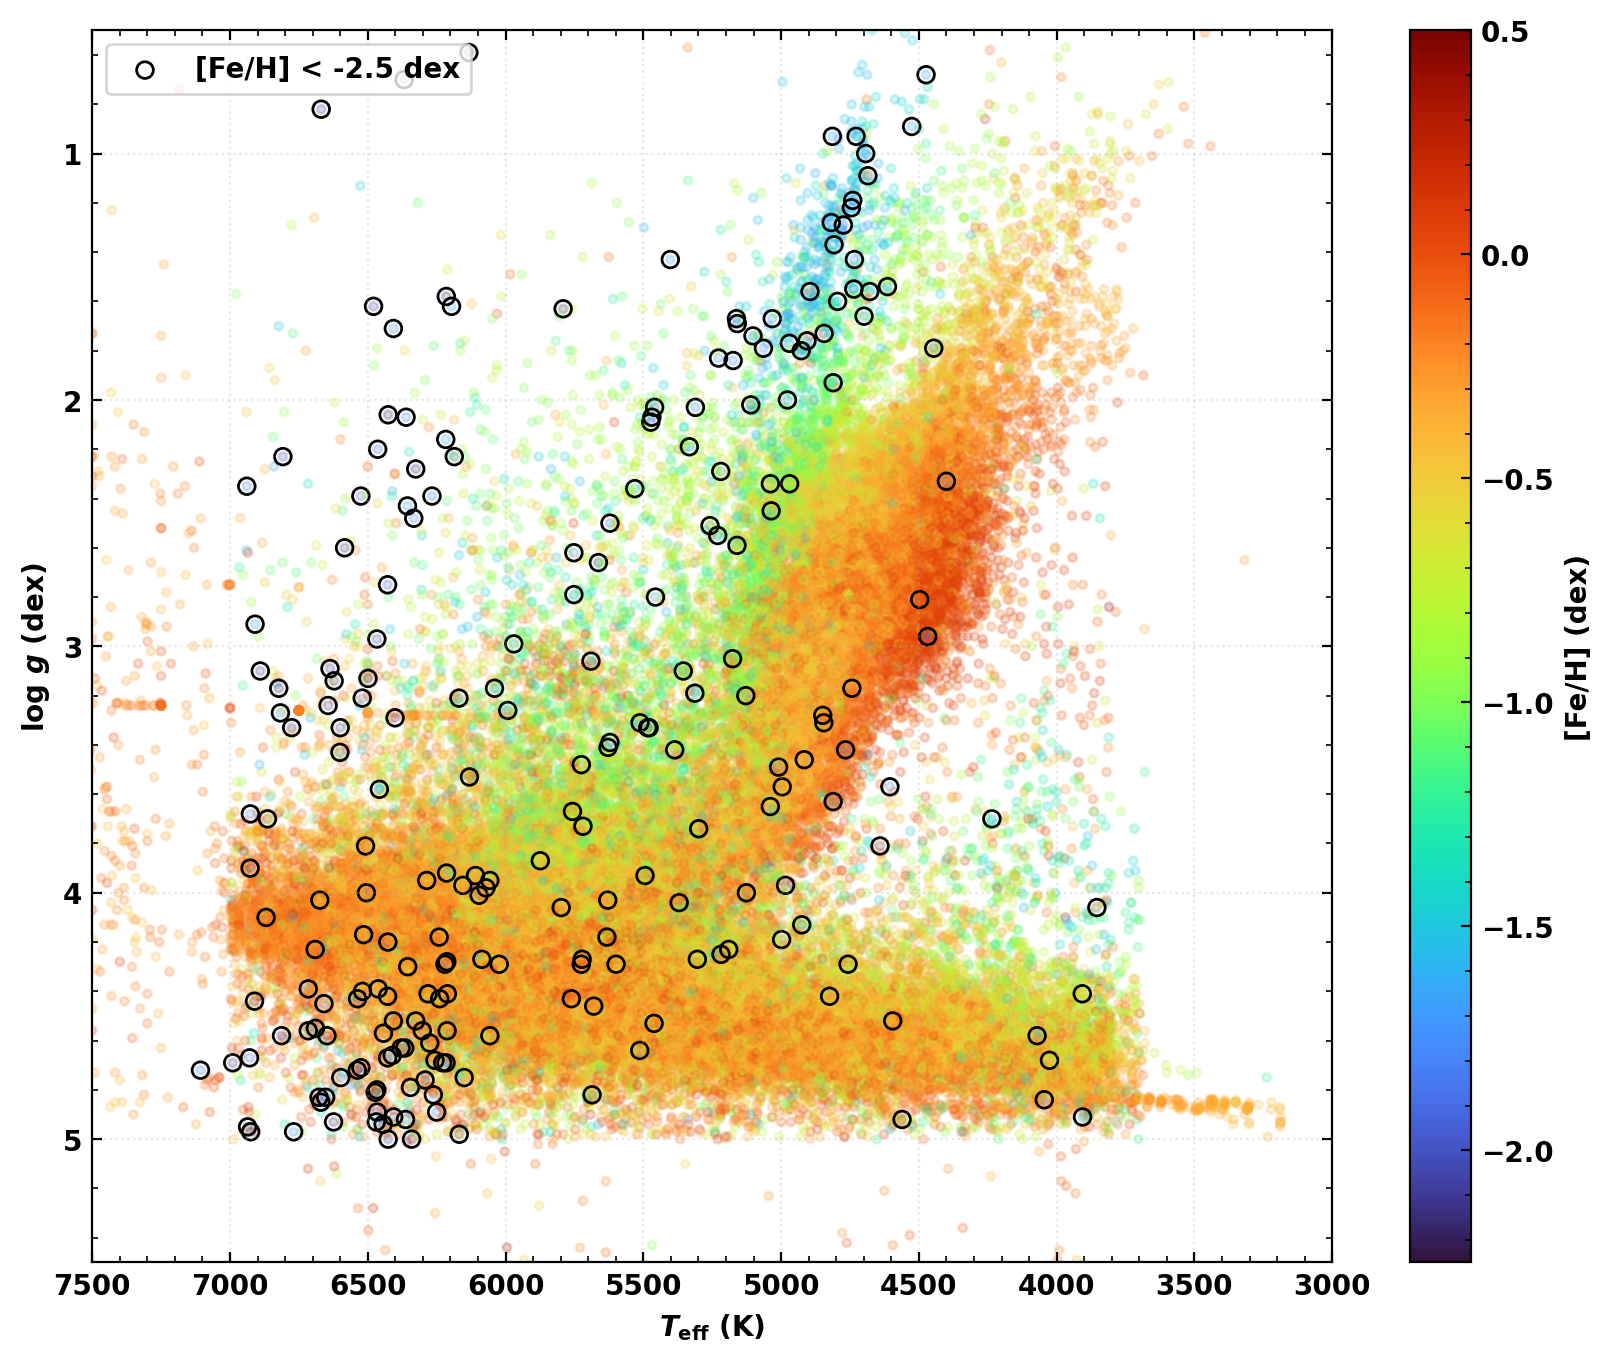

In [10]:
# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Scatter plot of all data points with metallicity as the color scale
ax.scatter(teff, logg, c=meta, alpha=0.2, marker='.', cmap='turbo')

# Add a dummy data for colorbar to the plot
vmin = -2.25
vmax = 0.5
im = ax.scatter([np.nan]*2, [np.nan]*2, c=[vmin, vmax], marker='.', cmap='turbo', vmin=vmin, vmax=vmax)

# Highlight metal-poor stars with [Fe/H] < METAL_LIMIT
metal_poor_mask = meta < METAL_LIMIT
ax.scatter(teff[metal_poor_mask], logg[metal_poor_mask], c=meta[metal_poor_mask],
            alpha=1.0, fc='none', ec='k', label=fr'[Fe/H] < {METAL_LIMIT} dex')

# Set the color limits for the colorbar
cbar = plt.colorbar(im)
cbar.set_label(r'[Fe/H] (dex)')  # Label for the colorbar

# Set axis labels
ax.set_xlabel(r'$T_\mathrm{eff}$ (K)')
ax.set_ylabel(r'$\log\,g$ (dex)')
ax.set_xlim(7500., 3000.)  # Reverse x-axis for a typical HR diagram
ax.set_ylim(5.5, 0.5)  # Reverse y-axis for proper representation of log(g)

ax.legend(loc='upper left')  # Add legend at the upper left corner
ax.grid(True, ls=':', alpha=0.3) # Add a grid with dashed lines

# Save the figure
plt.savefig('./figures/gaiaeso.png', format='png', bbox_inches='tight')

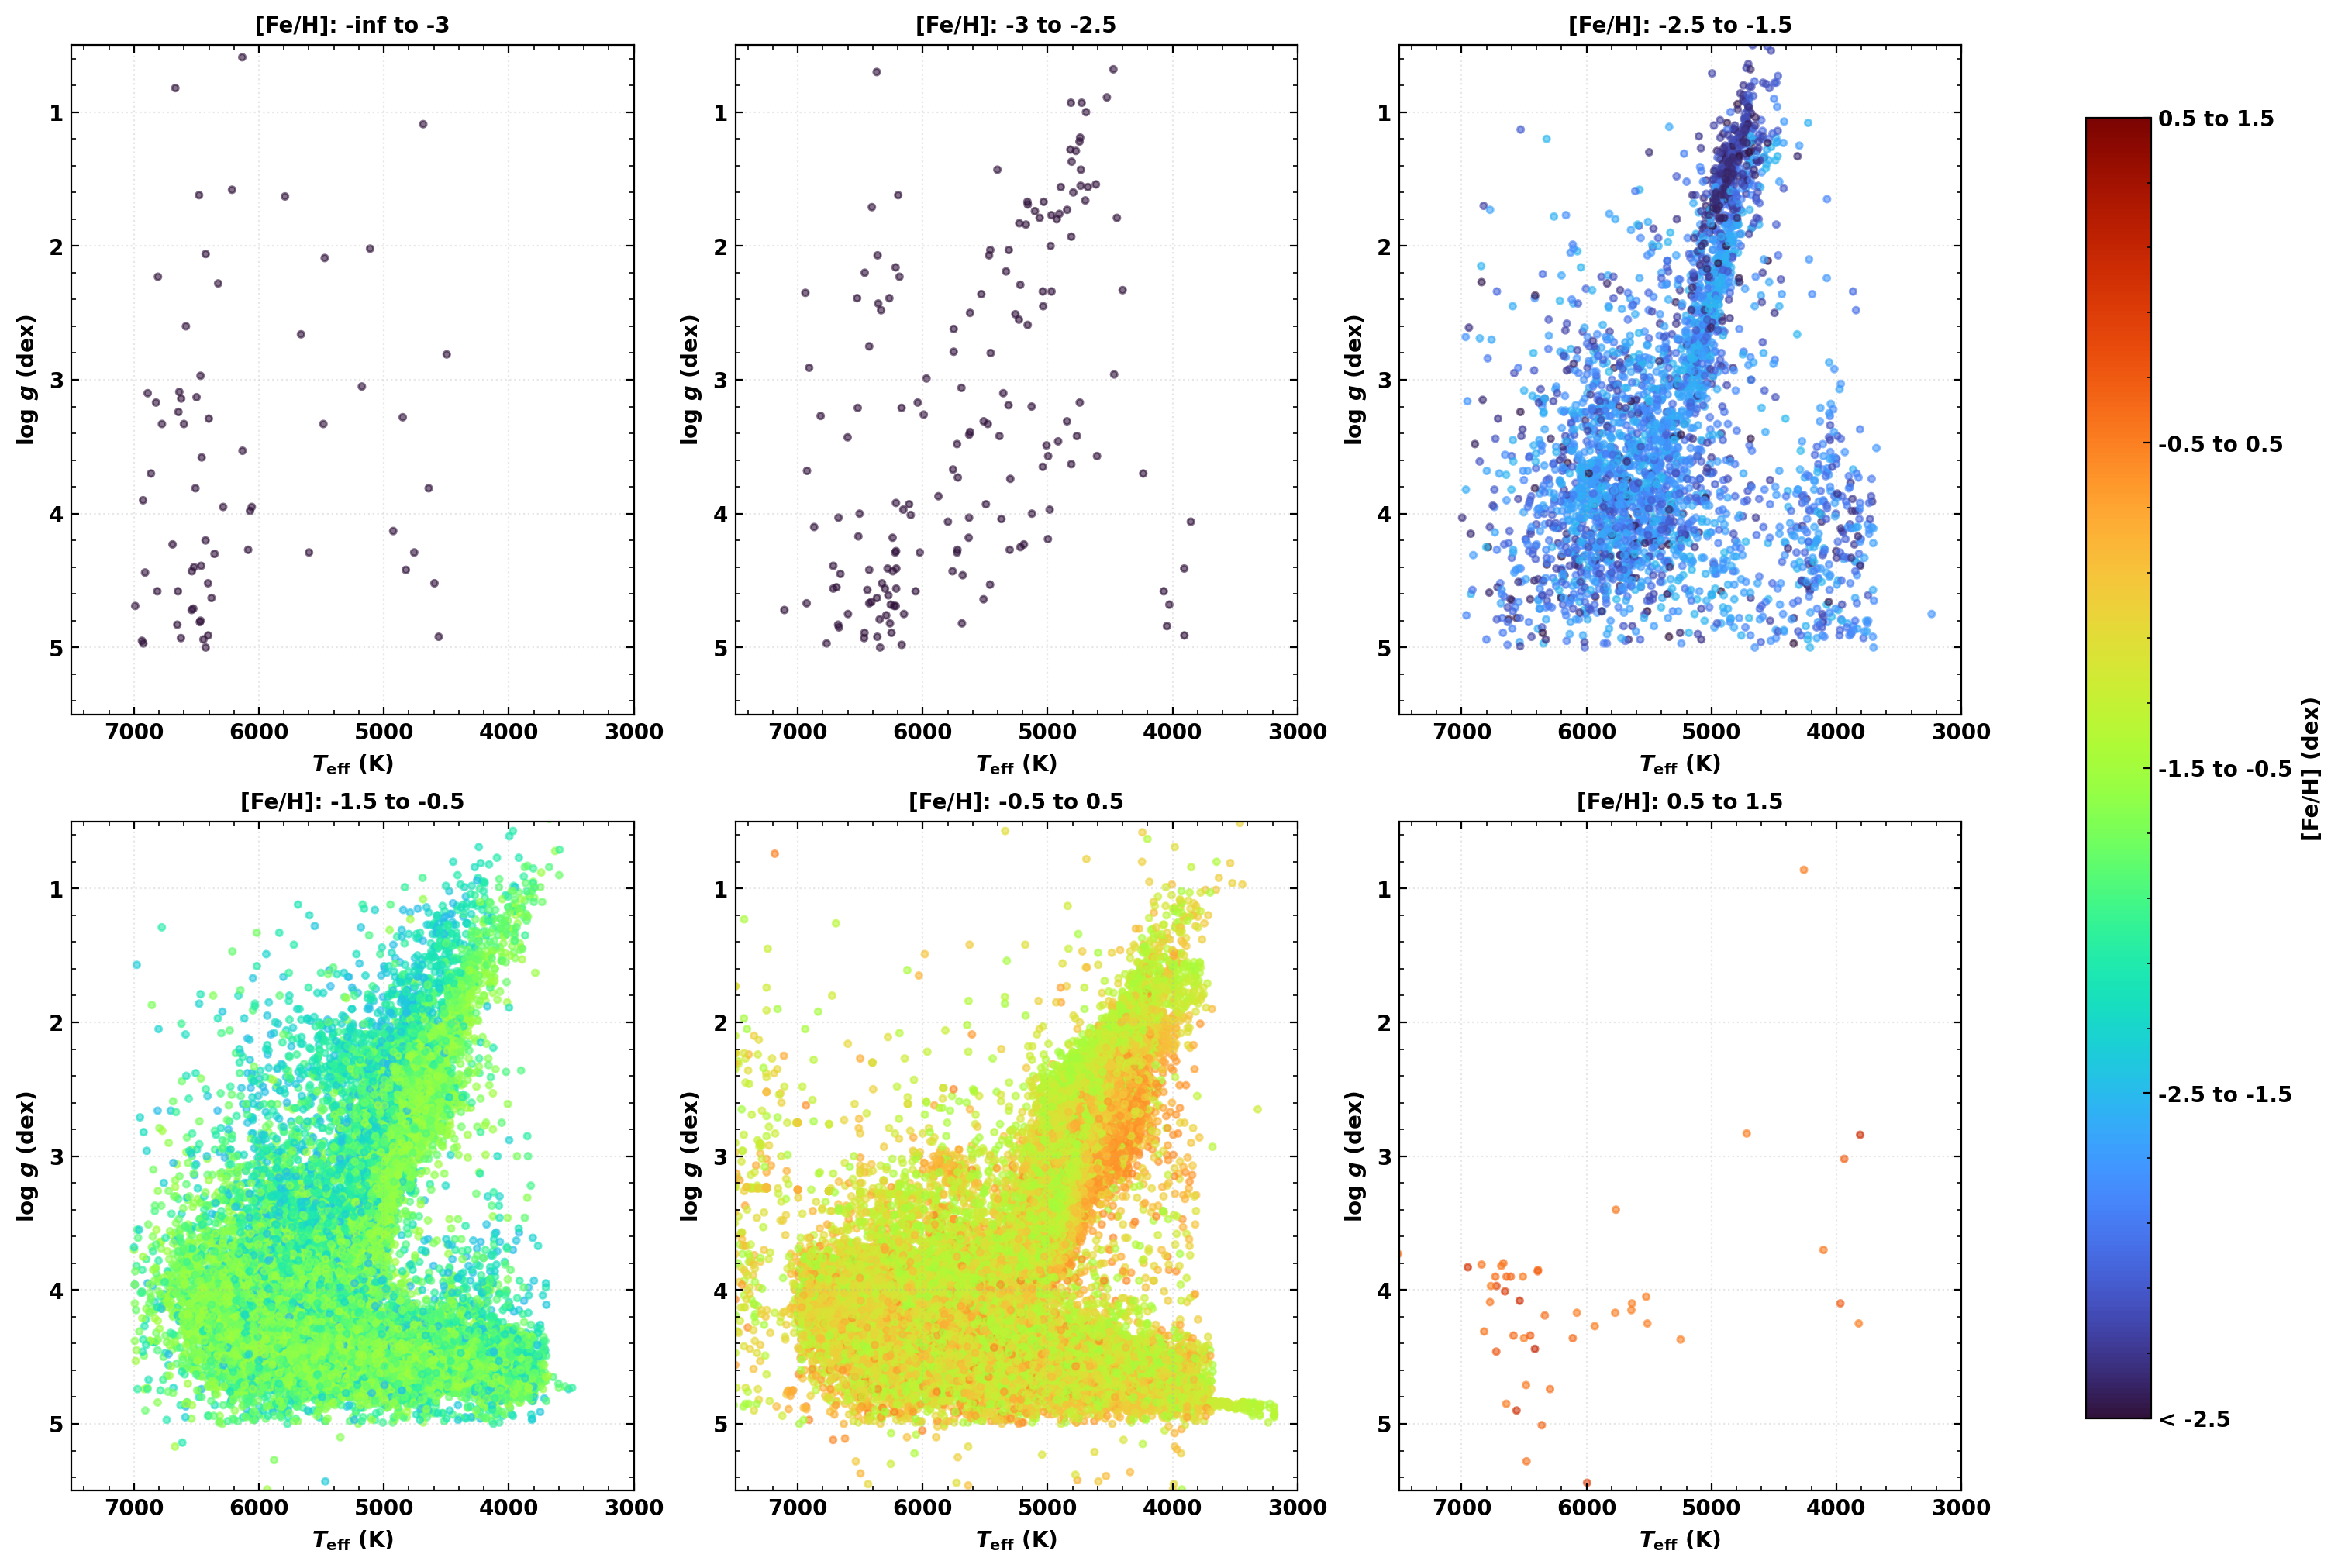

In [11]:
# Create a 2x3 figure with shared colorbar 
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

# Flatten the axes array for easier iteration and remove the last unused subplot
axes = axes.flatten()

# Define metallicity bins and colors
metal_bins = [-np.inf, -3, -2.5, -1.5, -0.5, 0.5, 1.5]
cmap = plt.cm.turbo
norm = plt.Normalize(vmin=-2.5, vmax=1.5)

# Iterate over each metallicity range
for i, ax in enumerate(axes):

    # Scatter plot for the given metallicity bin
    mask = (meta >= metal_bins[i]) & (meta < metal_bins[i + 1])
    ax.scatter(teff[mask], logg[mask], c=meta[mask], alpha=0.6, marker='.', cmap=cmap, norm=norm)

    # Add a dummy data for colorbar to the plot
    vmin = -2.5
    vmax = 1.5
    im = ax.scatter([np.nan]*2, [np.nan]*2, c=[vmin, vmax], marker='.', cmap='turbo', vmin=vmin, vmax=vmax)
    
    # Add labels and styling
    ax.set_xlabel(r'$T_\mathrm{eff}$ (K)')
    ax.set_ylabel(r'$\log\,g$ (dex)')
    ax.set_xlim(7500., 3000.)  # Reverse x-axis
    ax.set_ylim(5.5, 0.5)  # Reverse y-axis
    ax.set_title(f"[Fe/H]: {metal_bins[i]} to {metal_bins[i + 1]}", fontsize=10)
    ax.grid(True, ls=':', alpha=0.3)

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.9, pad=0.05)
cbar.set_label(r'[Fe/H] (dex)')
cbar.set_ticks([-2.5, -1.5, -0.5, 0.5, 1.5])
cbar.set_ticklabels(["< -2.5", "-2.5 to -1.5", "-1.5 to -0.5", "-0.5 to 0.5", "0.5 to 1.5"])

# Save the figure
plt.savefig('./figures/gaiaeso_2x3.png', format='png', bbox_inches='tight')


The properties of these metal poor stars can be checkd by slicing the `GAIAESO` table:

---
## <a id='Find spectra'>2. Find science ready spectra of the selected stars </a>

Now we want to have on disk all the spectroscopic data present in the ESO archive that targeted the selected metal poor stars. This could be done with the function <code>archive_observations.query_from_radec</code>. This will allow you to investigate the presence of processed data within a certain radius in arcseconds (e.g., `radius=5.`) from a given position. The position of the star is given as an `astropy.SkyCoord` object that could be created simply using:
```python
SkyCoord(ra=235.758999*u.degree, dec=-10.934527*u.degree)
```
We will thus first create a list of positions and then query the archive (given that the goal is to obtain the reduced spectra we limit the search to `data_types='spectrum'`):

In [12]:
# Select all low-metallicity stars from the GAIA-ESO survey
select_metal_poor = (gaiaeso['FEH'].data<METAL_LIMIT) # Select the metal-poor stars
gaiaeso_metal_poor = gaiaeso[select_metal_poor] # Get the metal-poor stars

star_positions = [] # List to store the positions of the stars
for ra_star, dec_star in zip(gaiaeso_metal_poor['RA'].data, gaiaeso_metal_poor['DECLINATION'].data):
    star_positions.append(SkyCoord(ra=ra_star*u.degree, dec=dec_star*u.degree), ) # Append the coordinates to the list

# Query the ESO archive for observations of the selected metal-poor stars within optical wavelengths
result_from_queries = archive_observations.query_from_radec(star_positions, radius=5., data_types= 'spectrum', verbose=False,
                                                            em_min=4.0e-7, em_max=1.2e-6)   

# Print the number of observations found for first star only
result_from_queries[0].show_in_notebook(show_row_index=False, display_length=5)

[WORKING] :: Running query 1 to the ESO archive (out of 234 total)
[INFO]    :: A total of 2 entries has been retrieved
[WORKING] :: Running query 2 to the ESO archive (out of 234 total)
[INFO]    :: A total of 6 entries has been retrieved
[WORKING] :: Running query 3 to the ESO archive (out of 234 total)
[INFO]    :: A total of 3 entries has been retrieved
[WORKING] :: Running query 4 to the ESO archive (out of 234 total)
[INFO]    :: A total of 4 entries has been retrieved
[WORKING] :: Running query 5 to the ESO archive (out of 234 total)
[INFO]    :: A total of 4 entries has been retrieved
[WORKING] :: Running query 6 to the ESO archive (out of 234 total)
[INFO]    :: A total of 4 entries has been retrieved
[WORKING] :: Running query 7 to the ESO archive (out of 234 total)
[INFO]    :: A total of 2 entries has been retrieved
[WORKING] :: Running query 8 to the ESO archive (out of 234 total)
[INFO]    :: A total of 14 entries has been retrieved
[WORKING] :: Running query 9 to the ESO

The result is stored in a list of astropy tables (one per star) containing relevant informations on the data collected.

For instanece, for the famous star [HD 140283](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+140283) the ESO archive contains a large number of datasets collected with the instruments ``GIRAFFE``, ``UVES``, and ``XSHOOTER``

In [13]:
# Select the star HD 140283
select_HD140283 = gaiaeso['OBJECT'] == '15430220-1056042' # ID of HD 140283 in the GAIA-ESO survey
gaiaeso_HD140283 = gaiaeso[select_HD140283]

star_positions = [] # List to store the positions of the stars
for ra_star, dec_star in zip(gaiaeso_HD140283['RA'].data, gaiaeso_HD140283['DECLINATION'].data):
    star_positions.append(SkyCoord(ra=ra_star*u.degree, dec=dec_star*u.degree), ) # Append the coordinates to the list

# Query the ESO archive for observations of the selected metal-poor stars within optical wavelengths
result_from_queries = archive_observations.query_from_radec(star_positions, radius=30., data_types= 'spectrum', verbose=False,
                                                            em_min=4.0e-7, em_max=1.2e-6)

result_from_queries.show_in_notebook(show_row_index=False, display_length=5)

[WORKING] :: Running query 1 to the ESO archive (out of 1 total)
[INFO]    :: A total of 260 entries has been retrieved


In [14]:
# filter result_from_queries to get obs_collection from GAIAESO, GIRAFFE, UVES, XSL
select_collections = (result_from_queries['obs_collection'] == 'GAIAESO') | (result_from_queries['obs_collection'] == 'GIRAFFE') | (result_from_queries['obs_collection'] == 'UVES') | (result_from_queries['obs_collection'] == 'XSL')
result_from_queries = result_from_queries[select_collections] 

### <a id='Download spectra'>2.1 Download science ready spectra of the selected stars </a>

Now it is time to download the spectra that you are interested in. This is done by feeding the `dp_id` column to `archive_observations.download`.

In [21]:
archive_observations.download(result_from_queries['dp_id'], output_dir='./data/')

[INFO]    :: Your disk has:
[INFO]    :: Total: 926.35 GB, Used: 680.25 GB, Free: 246.10 GB
[WARNING] :: File ADP.2017-05-11T07:30:20.274.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:20.279.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:20.335.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:20.337.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:36.426.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:36.430.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:36.437.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:39.798.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:39.804.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:39.806.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:39.827.fits already exists in ./data/
[WARNING] :: File ADP.2017-05-11T07:30:39.833.fits already ex

---
## <a id='Explore data'>3. Explore the data... </a>

Now you have all the optical spectra on your disk and it is time to explore them! Here we read in all files and plot the spectral regions around the H$\alpha$ line. Note that given that the `GIRAFFE` data are not flux calibrated we show only the normalized spectra.

### <a id='Get spectra'>3.1 Load and Normalise the spectra </a>

Extract the spectral information for plotting with the following ``extract_spectrum`` function. 
This applies the wavelengths corrections to get everything in ``SPECSYS`` in ``BARYCENT`` (from ``TOPOCENT`` or ``SOURCE``).
Some of the data do not have the correction factors for ``TOPOCENT`` so we calculate this from ``PyAstronomy`` package. 
Here we impose ``check_bary`` to see the correction factors, but this does not always mean they are applied.

In [22]:
def extract_spectrum(hdu, verbose=False):
    """
    Extracts and processes the spectrum from a FITS file.

    Parameters:
        hdu: HDUList object from the opened FITS file.
        verbose: Boolean flag to print additional details (default: False).

    Returns:
        spec_wave: Corrected wavelength array.
        spec_flux: Corrected flux array.
        spec_err: Corrected error array.
        instrument: Name of the instrument used for observation.
    """
    # Access primary (HDU 0) and data (HDU 1) headers
    hdu_0 = hdu[0]
    hdu_1 = hdu[1]

    # Determine wavelength correction factor based on units
    if hdu_1.header['TUNIT1'] == 'nm':
        wave_corr = 10.  # Convert from nm to Angstroms
    else:
        wave_corr = 1.  # Already in Angstroms

    # Retrieve instrument name from the primary header
    instrument = hdu_0.header['INSTRUME']

    # Perform barycentric correction
    if 'HIERARCH ESO QC VRAD BARYCOR' in hdu_0.header: 
        barycorr = hdu_0.header['HIERARCH ESO QC VRAD BARYCOR']
        wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr}')

    elif (hdu_0.header["SPECSYS"] == 'TOPOCENT') and ('HIERARCH ESO QC VRAD BARYCOR' not in hdu_0.header):
    
        ra = hdu[0].header['RA']
        dec = hdu[0].header['DEC']
        jd = hdu[0].header['MJD-OBS']
        heliocorr, barycorr = pyasl.baryCorr(jd, ra, dec)
        wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr} (using PyAstronomy)')
        
    if hdu_0.header['SPECSYS'] == 'SOURCE':
        sourcecorr = hdu_0.header['REST_VAL']
        wave_corr *= (1. + (sourcecorr/const.c.to('km/s').value))
        print(f'Source correction for {instrument}: {sourcecorr}')

    # Assign flux correction factor based on the instrument
    if instrument == 'MUSE':
        flux_corr = 1.  # No correction needed for MUSE
    elif instrument == 'XSHOOTER':
        flux_corr = 1.  # No correction needed for XSHOOTER
    elif instrument == 'UVES':
        flux_corr = 1e-16  # Scale flux by 1e-16 for UVES
    elif instrument == 'GIRAFFE':
        flux_corr = 1.  # No correction needed for GIRAFFE
    else:
        # Handle unknown instruments
        print(' - instrument not known')
        wave_corr = 0.
        flux_corr = 0.

    # Attempt to extract the data arrays, falling back to alternative keys if needed
    try:
        spec_wave = hdu_1.data['WAVE'].squeeze() * wave_corr
        spec_flux = hdu_1.data['FLUX'].squeeze() * flux_corr
        spec_err = hdu_1.data['ERR'].squeeze() * flux_corr
    except KeyError:
        # Alternative data column names for not calibrated data
        spec_wave = hdu_1.data['WAVE'].squeeze() * wave_corr
        spec_flux = hdu_1.data['FLUX_REDUCED'].squeeze() * flux_corr
        spec_err = hdu_1.data['ERR_REDUCED'].squeeze() * flux_corr

    # Replace zero values in flux and error with NaN for better handling
    spec_flux[spec_flux == 0] = np.nan
    spec_err[spec_err == 0] = np.nan

    # Verbose output to display spectrum details if requested
    if verbose:
        print(f'Content of the {instrument} spectrum: \n{hdu_1.columns} \n')

    # Return the processed arrays and instrument name
    return spec_wave, spec_flux, spec_err, instrument

In [23]:
# Initialize lists to store various properties of the spectra
spec_wave_arr = []  # List to store the wavelength arrays
spec_vel_arr = []  # List to store the velocity arrays
spec_flux_arr = []  # List to store the flux arrays
spec_flux_norm_arr = []  # List to store the normalized flux arrays
spec_err_arr = []  # List to store the error arrays
instrument_array_arr = []  # List to store the instrument names

# Loop through each data product ID in the query result
for dp_id in result_from_queries['dp_id']:
    # Construct the file path for the FITS file corresponding to the data product ID
    file_name = f'./data/{dp_id}.fits'
    
    # Check if the file exists; if not, skip to the next iteration
    if not os.path.isfile(file_name):
        continue
    else:
        print(f'File: {file_name}')  # Print the file name for tracking

    # Open the FITS file
    hdu = fits.open(file_name)
    
    # Extract the spectrum data: wavelength, flux, error, and instrument information
    spectrum_wave, spectrum_flux, spectrum_err, instrument = extract_spectrum(hdu, verbose=False)
    
    print(f' - instrument: {instrument}')  # Print the instrument name

    # Normalize the flux to 1 within the region of 6575–6585 Å (around H-alpha)
    try:
        # Define the normalization region as a boolean mask
        norm_region = (spectrum_wave > 6575.) & (spectrum_wave < 6585.)
        
        # Proceed only if there is data within the normalization region
        if len(spectrum_flux[norm_region]) > 0:
            # Calculate the normalization factor as the median flux in the region
            norm_factor = np.nanmedian(spectrum_flux[norm_region])
            
            # Convert wavelength to velocity using the rest wavelength of H-alpha (6562.793 Å)
            spectrum_vel = (spectrum_wave / 6562.793 - 1.) * 299792.458  # Velocity in km/s

            # Append the extracted and calculated data to the respective lists
            spec_wave_arr.append(spectrum_wave)  # Wavelength array
            spec_vel_arr.append(spectrum_vel)  # Velocity array
            spec_flux_arr.append(spectrum_flux)  # Flux array
            spec_flux_norm_arr.append(spectrum_flux / norm_factor)  # Normalized flux array
            spec_err_arr.append(spectrum_err)  # Error array
            instrument_array_arr.append(instrument)  # Instrument name

        else:
            print(' - spectrum not covering the plotting range')  # No data in the normalization range
    except Exception as e:
        # Handle any errors during the normalization or appending process
        print(f' - spectrum not plotted due to an error: {e}')


File: ./data/ADP.2017-05-11T07:30:20.274.fits
 - instrument: GIRAFFE
File: ./data/ADP.2017-05-11T07:30:20.279.fits
 - instrument: GIRAFFE
File: ./data/ADP.2017-05-11T07:30:20.335.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.337.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:36.426.fits
 - instrument: UVES
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:36.430.fits
 - instrument: UVES
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:36.437.fits
 - instrument: UVES
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:39.798.fits
 - instrument: UVES
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:39.804.fits
 - instrument: UVES
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:39.806.fits
 - instrument: UVES
 - spectrum not cove

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Barycentric correction for UVES: -29.5988597147348 (using PyAstronomy)
 - instrument: UVES
File: ./data/ADP.2023-06-01T16:03:04.854.fits
 - instrument: UVES
File: ./data/ADP.2017-05-11T07:30:20.260.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.294.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.296.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.308.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.325.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.333.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.341.fits
 - instrument: GIRAFFE
 - spectrum not covering the plotting range
File: ./data/ADP.2017-05-11T07:30:20.346.fits
 - ins

### <a id='PLot Spectra'>3.2 Plot Spectra </a>

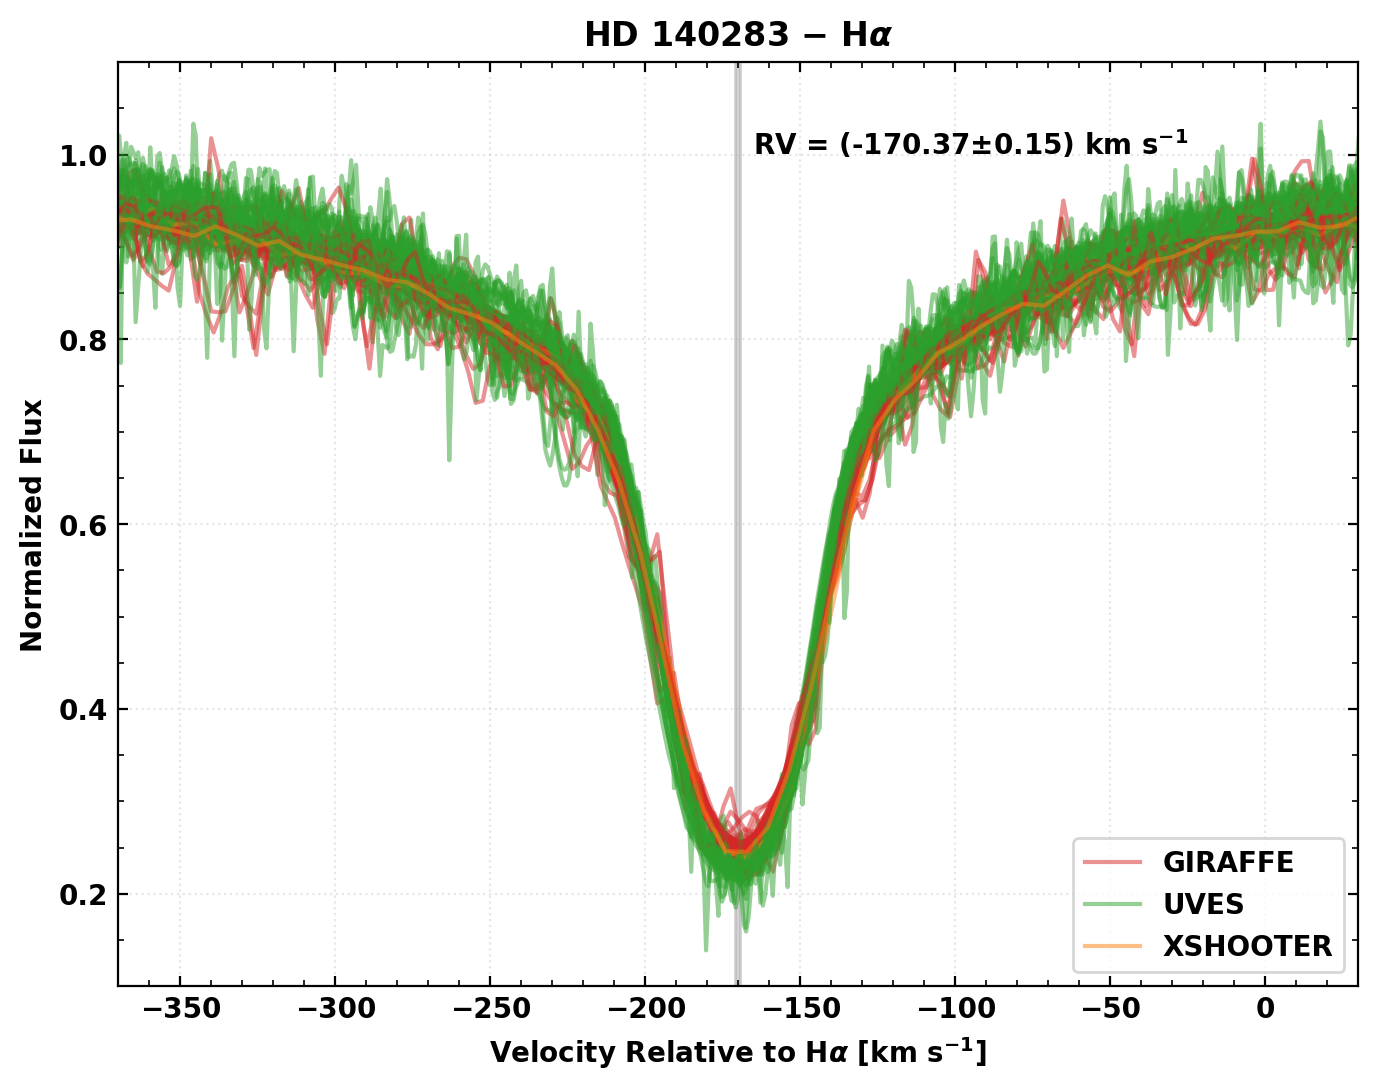

In [29]:
# Create a figure and a single subplot
fig = plt.figure(figsize=(8, 6))  # Set the size of the figure
ax = fig.add_subplot(111)         # Add a single subplot to the figure

# Define the radial velocity and plot a shaded region around it
radial_velocity = -170.37  # Radial velocity in km/s
ax.fill_between(
    [radial_velocity - 0.8, radial_velocity + 0.8],  # X-range for the shaded region
    y1=2,  # Upper bound of the shaded region
    y2=0,  # Lower bound of the shaded region
    alpha=0.5,  # Transparency level of the shading
    color='darkgrey'  # Color of the shaded region
)

# Loop through the spectral data arrays and plot them
for i in range(len(spec_wave_arr)):
    # Determine the shift and color based on the instrument type
    if instrument_array_arr[i] == 'XSHOOTER':
        shift = +5  # Apply a positive shift to velocities for this instrument
        color = 'C1'  # Matplotlib default color C1
    elif instrument_array_arr[i] == 'UVES':
        shift = 0  # No shift applied for this instrument
        color = 'C2'  # Matplotlib default color C2
    elif instrument_array_arr[i] == 'GIRAFFE':
        shift = 0  # No shift applied for this instrument
        color = 'C3'  # Matplotlib default color C3
    else:
        color = 'C4'  # Fallback color for unspecified instruments
        shift = 0  # Default to no shift
    
    # Plot the spectral velocity (with shift applied) and normalized flux
    ax.plot(
        spec_vel_arr[i] - shift,   # Adjust velocities by the shift amount
        spec_flux_norm_arr[i],    # Normalized flux values
        label=instrument_array_arr[i],  # Label for the legend
        color=color,              # Line color
        alpha=0.5                 # Line transparency
    )

# Set the X and Y axis limits
ax.set_xlim(-370., +30.)  # Range for velocity
ax.set_ylim(0.1, 1.1)     # Range for normalized flux

# Add axis labels
ax.set_xlabel(r'Velocity Relative to H$\alpha$ [km s$^{-1}$]')  # X-axis label with LaTeX-style formatting
ax.set_ylabel(r'Normalized Flux')                               # Y-axis label

# Create a legend with unique entries
handles, labels = plt.gca().get_legend_handles_labels()  # Get current legend handles and labels
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]  # Remove duplicates
ax.legend(*zip(*unique), loc='lower right')  # Add the legend to the plot

# Add a grid to the plot
ax.grid(True, ls=':', alpha=0.3)  # Dashed grid lines with slight transparency

# Add a title to the plot
ax.set_title(r'HD 140283 $-$ H$\alpha$')  # Title with LaTeX-style formatting

# Add a text annotation to indicate the radial velocity
ax.text(
    radial_velocity + 5,  # X-coordinate for the text
    1,                    # Y-coordinate for the text
    r'RV = (-170.37$\pm$0.15) km s$^{-1}$',  # Text content with uncertainty
    horizontalalignment='left'  # Align text to the left
)

# Save the figure to a file
plt.savefig('./figures/HD140283.png', format='png', bbox_inches='tight')  # Save figure with tight layout